In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


In [246]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor


# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import torchvision

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline


# utils
import numpy as np
from torchsummary import summary
import time
import copy
import pandas as pd

import os
from warnings import filterwarnings
filterwarnings('ignore')

import torch
from torch import nn, optim
from torch.backends import cudnn
cudnn.benchmark = True
from randaugment import RandAugment, ImageNetPolicy

import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'

import tensorflow as tf

In [247]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [248]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None )

True

In [249]:
train =pd.read_csv("../data/train.csv")
submission = pd.read_csv("../data/sample_submission.csv")

In [250]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23011 entries, 0 to 23010
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일시      23011 non-null  object 
 1   최고기온    23008 non-null  float64
 2   최저기온    23008 non-null  float64
 3   일교차     23007 non-null  float64
 4   강수량     9150 non-null   float64
 5   평균습도    23011 non-null  float64
 6   평균풍속    23007 non-null  float64
 7   일조합     22893 non-null  float64
 8   일사합     18149 non-null  float64
 9   일조율     22645 non-null  float64
 10  평균기온    23011 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.9+ MB


In [251]:
train['년'] = train['일시'].apply(lambda x : x.split('-')).apply(lambda x: x[0]).astype('int64')
train['월'] = train['일시'].apply(lambda x : x.split('-')).apply(lambda x: x[1]).astype('int64')
train['일'] = train['일시'].apply(lambda x : x.split('-')).apply(lambda x: x[2]).astype('int64')

In [252]:
train['일시'] = pd.to_datetime(train['일시'])

In [253]:
train.isnull().sum()

일시          0
최고기온        3
최저기온        3
일교차         4
강수량     13861
평균습도        0
평균풍속        4
일조합       118
일사합      4862
일조율       366
평균기온        0
년           0
월           0
일           0
dtype: int64

In [254]:
train[['최고기온', '최저기온', '일교차','평균풍속','일조합']] = train[['최고기온','최저기온','일교차','평균풍속','일조합']].fillna(method='ffill')

In [255]:
train.isnull().sum()

일시          0
최고기온        0
최저기온        0
일교차         0
강수량     13861
평균습도        0
평균풍속        0
일조합         0
일사합      4862
일조율       366
평균기온        0
년           0
월           0
일           0
dtype: int64

In [256]:
train_linear = train[['일조합','일조율']]
train_linear.dropna(axis = 0 ,inplace = True)

X_train_linear = train_linear['일조합'].values.reshape(-1,1)
y_train_linear = train_linear['일조율']

In [257]:
model = LinearRegression()
model.fit(X_train_linear,y_train_linear)

LinearRegression()

In [258]:
missing1 = train[train['일조율'].isnull()]['일조합'].values.reshape(-1,1)
missing1

array([[ 6.7],
       [ 0. ],
       [ 0. ],
       [ 2.6],
       [ 8.2],
       [ 7.7],
       [ 1.9],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 8.2],
       [ 4.9],
       [ 6.7],
       [ 6. ],
       [ 0. ],
       [ 1.4],
       [ 7. ],
       [ 0. ],
       [ 5.7],
       [ 0.3],
       [ 7. ],
       [ 8.7],
       [ 7.7],
       [ 9.1],
       [ 6.9],
       [ 8.1],
       [ 8.6],
       [ 9.5],
       [ 8.3],
       [ 7.1],
       [ 1.6],
       [ 4.8],
       [ 5.2],
       [ 7.8],
       [ 7.7],
       [ 6.3],
       [ 7.8],
       [ 4.5],
       [ 0.8],
       [ 2.9],
       [ 9.6],
       [ 6. ],
       [ 9.4],
       [ 0.6],
       [ 8.5],
       [ 9. ],
       [ 5.3],
       [ 3. ],
       [ 9.3],
       [ 9.4],
       [ 0. ],
       [ 8.9],
       [ 8.6],
       [ 8.9],
       [ 2.3],
       [ 0. ],
       [ 0. ],
       [ 9.7],
       [ 8.6],
       [ 4.4],
       [ 9.2],
       [ 6.4],
       [ 9.4],
       [ 9.1],
       [ 5.4],
       [ 0.9],
       [ 9

In [259]:
predicted_values1 = model.predict(missing1)

In [260]:
train.loc[train['일조율'].isnull(), '일조율'] = predicted_values1

In [261]:
train_linear = train[['일교차','일조합','일사합']]
train_linear.dropna(axis = 0 ,inplace = True)

X_train_linear = train_linear[['일교차','일조합']]
y_train_linear = train_linear['일사합']

In [262]:
model = LinearRegression()
model.fit(X_train_linear,y_train_linear)

LinearRegression()

In [263]:
missing2 = train[train['일사합'].isnull()][['일교차','일조합']]
missing2

,일교차,일조합
0,7.4,6.7
1,6.8,0.0
2,10.8,0.0
3,9.6,2.6
4,9.5,8.2
...,...,...
21230,7.7,3.3
21789,6.6,5.6
21790,6.3,4.9
22287,8.1,9.1


In [264]:
predicted_values2 = model.predict(missing2)

In [265]:
train.loc[train['일사합'].isnull(), '일사합'] = predicted_values2

In [266]:
train

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온,년,월,일
0,1960-01-01,2.2,-5.2,7.4,NaN,68.3,1.7,6.7,12.562132,55.338502,-1.6,1960,1,1
1,1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,4.541569,2.040280,-1.9,1960,1,2
2,1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,5.738938,2.040280,4.0,1960,1,3
3,1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,8.422487,22.723172,7.5,1960,1,4
4,1960-01-05,1.3,-8.2,9.5,NaN,44.0,5.1,8.2,14.946189,67.270939,-4.6,1960,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23006,2022-12-27,3.3,-7.3,10.6,NaN,69.8,1.8,8.8,10.250000,91.700000,-2.6,2022,12,27
23007,2022-12-28,0.1,-6.0,6.1,0.1,58.1,2.5,8.7,10.860000,90.600000,-3.3,2022,12,28
23008,2022-12-29,2.1,-7.8,9.9,0.0,56.3,1.7,9.0,10.880000,93.800000,-2.9,2022,12,29
23009,2022-12-30,2.3,-4.4,6.7,0.0,65.6,1.9,7.9,10.840000,82.300000,-1.8,2022,12,30


In [267]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23011 entries, 0 to 23010
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   일시      23011 non-null  datetime64[ns]
 1   최고기온    23011 non-null  float64       
 2   최저기온    23011 non-null  float64       
 3   일교차     23011 non-null  float64       
 4   강수량     9150 non-null   float64       
 5   평균습도    23011 non-null  float64       
 6   평균풍속    23011 non-null  float64       
 7   일조합     23011 non-null  float64       
 8   일사합     23011 non-null  float64       
 9   일조율     23011 non-null  float64       
 10  평균기온    23011 non-null  float64       
 11  년       23011 non-null  int64         
 12  월       23011 non-null  int64         
 13  일       23011 non-null  int64         
dtypes: datetime64[ns](1), float64(10), int64(3)
memory usage: 2.5 MB


In [268]:
# '월' 컬럼에 대한 순환 인코딩
train['월_sin'] = np.sin(2 * np.pi * train['월'] / 12)
train['월_cos'] = np.cos(2 * np.pi * train['월'] / 12)

# '일' 컬럼에 대한 순환 인코딩
train['일_sin'] = np.sin(2 * np.pi * train['일'] / 31)
train['일_cos'] = np.cos(2 * np.pi * train['일'] / 31)

In [269]:
train.drop(['월','일'], axis = 1 , inplace= True)

In [270]:
train.corr()

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온,년,월_sin,월_cos,일_sin,일_cos
일시,1.000000,0.048851,0.059392,-0.036074,0.017028,-0.231132,-0.042916,0.033099,0.059547,0.043585,0.056060,0.999874,-0.012097,0.003334,-0.001071,0.000143
최고기온,0.048851,1.000000,0.962787,0.182002,0.199178,0.306835,-0.227404,0.064057,0.369722,-0.122472,0.989544,0.045031,-0.519501,-0.755133,-0.000714,0.002021
최저기온,0.059392,0.962787,1.000000,-0.090501,0.262755,0.442914,-0.185639,-0.117398,0.203284,-0.293985,0.989335,0.055309,-0.558963,-0.747663,0.000841,0.003838
일교차,-0.036074,0.182002,-0.090501,1.000000,-0.277905,-0.480821,-0.162499,0.663260,0.622885,0.618420,0.046908,-0.035293,0.119413,-0.062413,-0.005669,-0.006467
강수량,0.017028,0.199178,0.262755,-0.277905,1.000000,0.419573,0.014570,-0.271334,-0.275124,-0.287762,0.237996,0.016303,-0.178306,-0.214765,-0.002598,0.006729
평균습도,-0.231132,0.306835,0.442914,-0.480821,0.419573,1.000000,-0.112050,-0.590401,-0.441476,-0.637937,0.376363,-0.233811,-0.332574,-0.220638,0.013363,0.016009
평균풍속,-0.042916,-0.227404,-0.185639,-0.162499,0.014570,-0.112050,1.000000,0.055687,0.036032,0.057614,-0.209176,-0.039845,0.273132,-0.021610,-0.007102,0.002692
일조합,0.033099,0.064057,-0.117398,0.663260,-0.271334,-0.590401,0.055687,1.000000,0.819652,0.959005,-0.030764,0.034325,0.105893,-0.046367,-0.004246,-0.006976
일사합,0.059547,0.369722,0.203284,0.622885,-0.275124,-0.441476,0.036032,0.819652,1.000000,0.684508,0.286129,0.061837,0.088243,-0.414872,-0.001692,-0.007552
일조율,0.043585,-0.122472,-0.293985,0.618420,-0.287762,-0.637937,0.057614,0.959005,0.684508,1.000000,-0.214855,0.044254,0.113570,0.165033,-0.006616,-0.005420


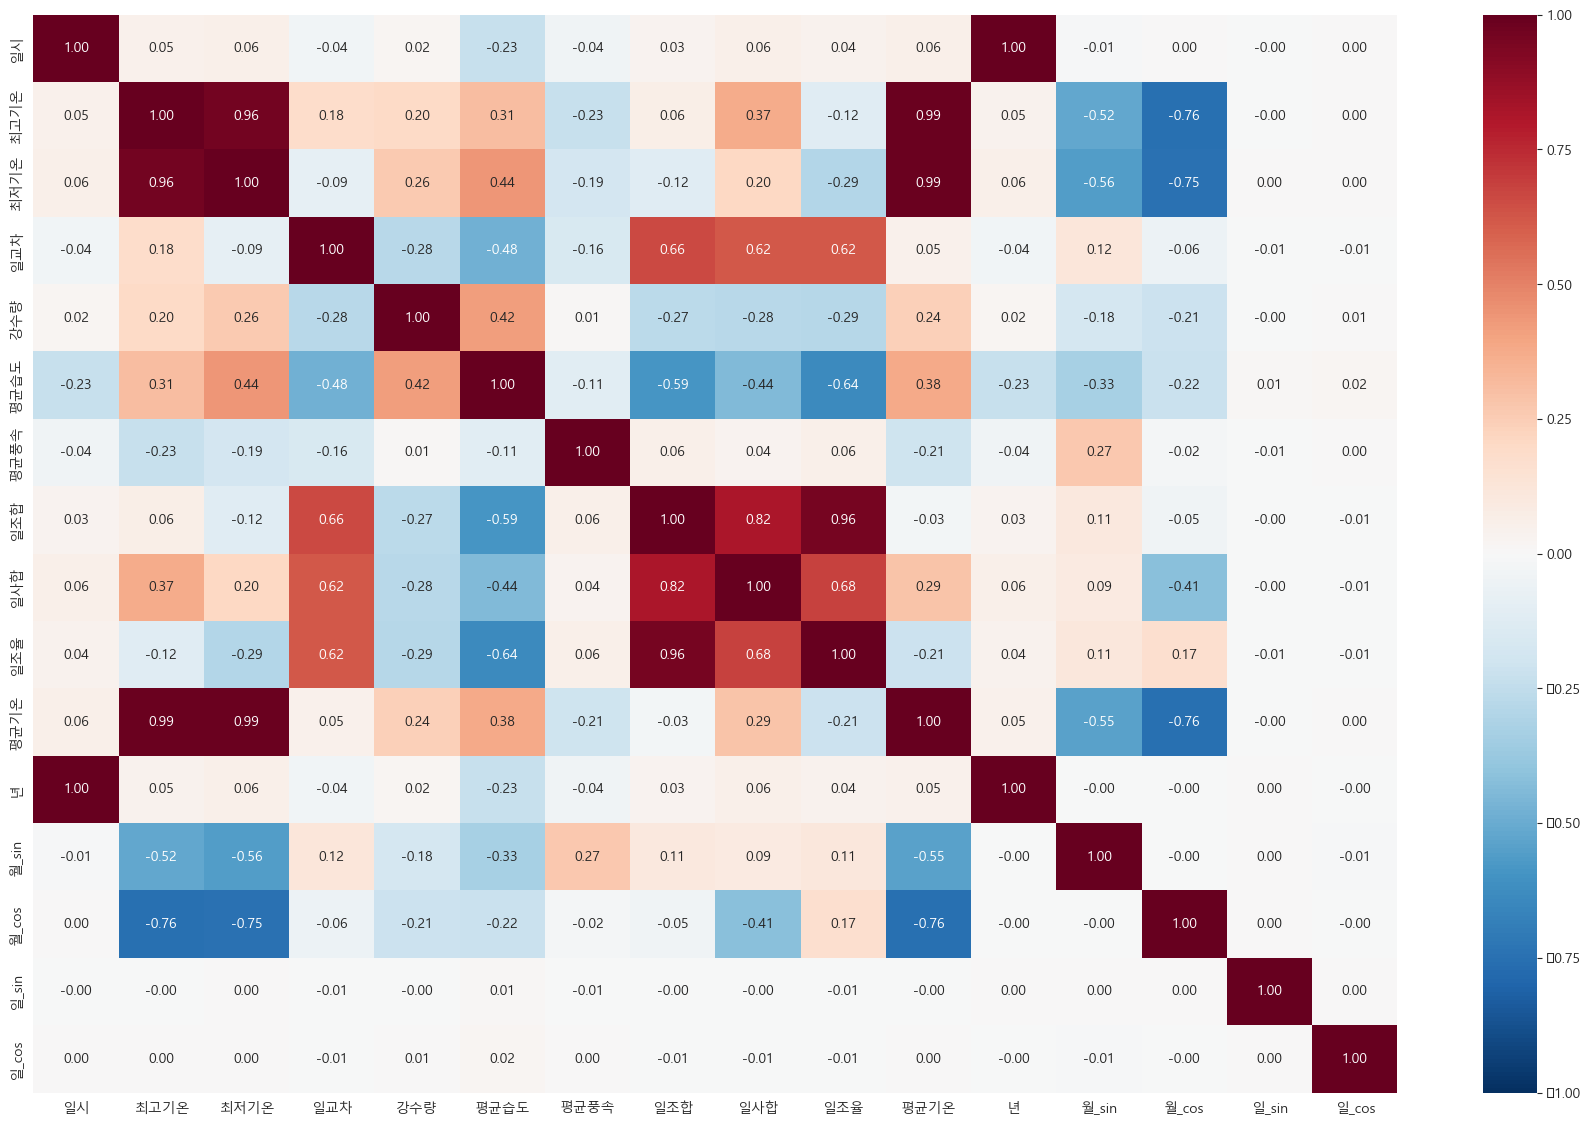

In [271]:
plt.figure(figsize=(22,14))
sns.heatmap(train.corr(), cmap='RdBu_r', vmax=1, vmin=-1, annot=True, fmt='.2f');

In [290]:
import math

train['강수량'] = train['강수량'].apply(lambda x :  math.log(x+1))

In [291]:
train_rainfall = train.dropna(axis=0)
test_rainfall = train[train['강수량'].isnull()].drop('강수량', axis = 1)

X_train_rainfall = train_rainfall.drop(['강수량'], axis = 1)
y_train_rainfall = train_rainfall['강수량']


In [292]:
X_train_rainfall

,일시,최고기온,최저기온,일교차,평균습도,평균풍속,일조합,일사합,일조율,평균기온,년,월_sin,월_cos,일_sin,일_cos
1,1960-01-02,1.2,-5.6,6.8,87.7,1.3,0.0,4.541569,2.040280,-1.9,1960,5.000000e-01,0.866025,3.943559e-01,0.918958
2,1960-01-03,8.7,-2.1,10.8,81.3,3.0,0.0,5.738938,2.040280,4.0,1960,5.000000e-01,0.866025,5.712682e-01,0.820763
3,1960-01-04,10.8,1.2,9.6,79.7,4.4,2.6,8.422487,22.723172,7.5,1960,5.000000e-01,0.866025,7.247928e-01,0.688967
5,1960-01-06,-1.2,-9.5,8.3,51.3,1.8,7.7,14.001833,63.293460,-5.2,1960,5.000000e-01,0.866025,9.377521e-01,0.347305
6,1960-01-07,6.0,-3.5,9.5,74.0,1.3,1.9,7.573348,17.154701,1.3,1960,5.000000e-01,0.866025,9.884683e-01,0.151428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23000,2022-12-21,2.6,-2.6,5.2,82.4,2.7,0.0,2.480000,0.000000,-0.1,2022,-2.449294e-16,1.000000,-8.978045e-01,-0.440394
23007,2022-12-28,0.1,-6.0,6.1,58.1,2.5,8.7,10.860000,90.600000,-3.3,2022,-2.449294e-16,1.000000,-5.712682e-01,0.820763
23008,2022-12-29,2.1,-7.8,9.9,56.3,1.7,9.0,10.880000,93.800000,-2.9,2022,-2.449294e-16,1.000000,-3.943559e-01,0.918958
23009,2022-12-30,2.3,-4.4,6.7,65.6,1.9,7.9,10.840000,82.300000,-1.8,2022,-2.449294e-16,1.000000,-2.012985e-01,0.979530


In [293]:
y_train_rainfall

1        0.336472
2        0.000000
3        0.000000
5        0.000000
6        0.095310
           ...   
23000    1.526056
23007    0.095310
23008    0.000000
23009    0.000000
23010    0.000000
Name: 강수량, Length: 9150, dtype: float64

In [294]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max Scaler 초기화
scaler = MinMaxScaler()

# Min-Max Scaling을 적용할 컬럼들 선택
columns_to_scale = ['최고기온', '일교차','최저기온', '평균습도', '평균풍속', '일조합', '일사합', '일조율', '평균기온', '년']

# Scaling 적용
X_train_rainfall[columns_to_scale] = scaler.fit_transform(X_train_rainfall[columns_to_scale])

In [295]:
X_train_rainfall

,일시,최고기온,최저기온,일교차,평균습도,평균풍속,일조합,일사합,일조율,평균기온,년,월_sin,월_cos,일_sin,일_cos
1,1960-01-02,0.252033,0.297959,0.331429,0.833563,0.155844,0.000000,0.149640,0.021522,0.285106,0.0,5.000000e-01,0.866025,3.943559e-01,0.918958
2,1960-01-03,0.404472,0.369388,0.560000,0.745530,0.376623,0.000000,0.189092,0.021522,0.410638,0.0,5.000000e-01,0.866025,5.712682e-01,0.820763
3,1960-01-04,0.447154,0.436735,0.491429,0.723521,0.558442,0.198473,0.277512,0.239696,0.485106,0.0,5.000000e-01,0.866025,7.247928e-01,0.688967
5,1960-01-06,0.203252,0.218367,0.417143,0.332875,0.220779,0.587786,0.461345,0.667653,0.214894,0.0,5.000000e-01,0.866025,9.377521e-01,0.347305
6,1960-01-07,0.349593,0.340816,0.485714,0.645117,0.155844,0.145038,0.249534,0.180957,0.353191,0.0,5.000000e-01,0.866025,9.884683e-01,0.151428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23000,2022-12-21,0.280488,0.359184,0.240000,0.760660,0.337662,0.000000,0.081713,0.000000,0.323404,1.0,-2.449294e-16,1.000000,-8.978045e-01,-0.440394
23007,2022-12-28,0.229675,0.289796,0.291429,0.426410,0.311688,0.664122,0.357825,0.955696,0.255319,1.0,-2.449294e-16,1.000000,-5.712682e-01,0.820763
23008,2022-12-29,0.270325,0.253061,0.508571,0.401651,0.207792,0.687023,0.358484,0.989451,0.263830,1.0,-2.449294e-16,1.000000,-3.943559e-01,0.918958
23009,2022-12-30,0.274390,0.322449,0.325714,0.529574,0.233766,0.603053,0.357166,0.868143,0.287234,1.0,-2.449294e-16,1.000000,-2.012985e-01,0.979530


In [296]:
X_train_rainfall.drop('최저기온' , axis = 1 , inplace= True)

In [297]:
# 훈련 세트와 검증 세트로 나누기 (비율 80:20)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_rainfall, y_train_rainfall, test_size=0.2, random_state=42)

In [298]:
# rf_predictions = rf_model.predict(X_valid)

In [299]:
# # 평균 절대 오차 (MAE) 계산
# mae = mean_absolute_error(y_valid, rf_predictions)
# 
# # R^2 (결정 계수) 계산
# r2 = r2_score(y_valid, rf_predictions)
# 
# print(f"MAE: {mae}")
# print(f"R^2: {r2}")

In [300]:
# # XGBoost 모델 훈련
# xgb_model = XGBRegressor()
# xgb_model.fit(X_train, y_train)

In [301]:
# xgb_predictions = xgb_model.predict(X_valid)

In [302]:
# # 평균 절대 오차 (MAE) 계산
# mae = mean_absolute_error(y_valid, xgb_predictions)
# 
# # R^2 (결정 계수) 계산
# r2 = r2_score(y_valid, xgb_predictions)
# 
# print(f"MAE: {mae}")
# print(f"R^2: {r2}")

In [312]:
# CatBoost 모델 훈련
cat_model = CatBoostRegressor( silent=True,iterations=300, depth = 8, l2_leaf_reg  = 0.001)  # silent=True로 설정하여 훈련 과정 중 메시지 출력을 방지
cat_model.fit(X_train, y_train)

In [313]:
cat_predictions = cat_model.predict(X_valid)

In [314]:
# 평균 절대 오차 (MAE) 계산
mae = mean_absolute_error(y_valid, cat_predictions)

# R^2 (결정 계수) 계산
r2 = r2_score(y_valid, cat_predictions)

print(f"MAE: {mae}")
print(f"R^2: {r2}")

MAE: 0.7463200916680881
R^2: 0.5249970646839378


In [311]:
# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'iterations': [200, 300],
    'depth': [6, 8],
    'l2_leaf_reg': [0.01, 0.001]
}

# CatBoost 모델 초기화
cat_model = CatBoostRegressor(silent=True)

# GridSearchCV 초기화
grid_search = GridSearchCV(cat_model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

In [307]:
# 그리드 서치 수행
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000002338AD73F40>,
             n_jobs=-1,
             param_grid={'depth': [6, 8], 'iterations': [200, 300],
                         'l2_leaf_reg': [0.01, 0.001]},
             scoring='neg_mean_absolute_error')

In [308]:
print("최적의 파라미터:", grid_search.best_params_)

최적의 파라미터: {'depth': 8, 'iterations': 300, 'l2_leaf_reg': 0.001}


In [309]:
print("최고 MAE 점수:", -grid_search.best_score_)

최고 MAE 점수: 0.7286356100129321


In [292]:
param_grid = {
    'num_leaves': [31, 62],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [20, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1]
}

# GridSearchCV 초기화
grid_search_lgbm = GridSearchCV(LGBMRegressor(), param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# 그리드 서치 수행
grid_search_lgbm.fit(X_train, y_train)

# 최적의 파라미터와 해당 스코어 출력
print("최적의 파라미터:", grid_search_lgbm.best_params_)
print("최고 점수:", -grid_search_lgbm.best_score_)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1976
[LightGBM] [Info] Number of data points in the train set: 7320, number of used features: 12
[LightGBM] [Info] Start training from score 9.448989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [315]:
predicted_values_rainfall = cat_model.predict(test_rainfall)

In [316]:
predicted_values_rainfall

array([2.0267317 , 1.88474038, 1.96951402, ..., 1.56650527, 2.08727231,
       2.03001686])

In [317]:
train.loc[train['강수량'].isnull(), '강수량'] = predicted_values_rainfall

In [319]:
train['강수량'] = train['강수량'].apply(lambda x : math.exp(x)-1)

In [321]:
train

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온,년,월_sin,월_cos,일_sin,일_cos
0,1960-01-01,2.2,-5.2,7.4,6.589242,68.3,1.7,6.7,12.562132,55.338502,-1.6,1960,5.000000e-01,0.866025,2.012985e-01,0.979530
1,1960-01-02,1.2,-5.6,6.8,0.400000,87.7,1.3,0.0,4.541569,2.040280,-1.9,1960,5.000000e-01,0.866025,3.943559e-01,0.918958
2,1960-01-03,8.7,-2.1,10.8,0.000000,81.3,3.0,0.0,5.738938,2.040280,4.0,1960,5.000000e-01,0.866025,5.712682e-01,0.820763
3,1960-01-04,10.8,1.2,9.6,0.000000,79.7,4.4,2.6,8.422487,22.723172,7.5,1960,5.000000e-01,0.866025,7.247928e-01,0.688967
4,1960-01-05,1.3,-8.2,9.5,5.584645,44.0,5.1,8.2,14.946189,67.270939,-4.6,1960,5.000000e-01,0.866025,8.486443e-01,0.528964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23006,2022-12-27,3.3,-7.3,10.6,6.614215,69.8,1.8,8.8,10.250000,91.700000,-2.6,2022,-2.449294e-16,1.000000,-7.247928e-01,0.688967
23007,2022-12-28,0.1,-6.0,6.1,0.100000,58.1,2.5,8.7,10.860000,90.600000,-3.3,2022,-2.449294e-16,1.000000,-5.712682e-01,0.820763
23008,2022-12-29,2.1,-7.8,9.9,0.000000,56.3,1.7,9.0,10.880000,93.800000,-2.9,2022,-2.449294e-16,1.000000,-3.943559e-01,0.918958
23009,2022-12-30,2.3,-4.4,6.7,0.000000,65.6,1.9,7.9,10.840000,82.300000,-1.8,2022,-2.449294e-16,1.000000,-2.012985e-01,0.979530


In [322]:
train.isnull().sum()

일시       0
최고기온     0
최저기온     0
일교차      0
강수량      0
평균습도     0
평균풍속     0
일조합      0
일사합      0
일조율      0
평균기온     0
년        0
월_sin    0
월_cos    0
일_sin    0
일_cos    0
dtype: int64

In [323]:
train.to_csv('../data/train_preprocessing2.csv', index=False)